<a href="https://colab.research.google.com/github/Rqkko/time-series-forecasting/blob/main/timeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
# Download Nikkei 225 Data
symbol = "^N225"
start_date = "2000-01-01"
end_date = "2025-05-31"
data = yf.download(symbol, start=start_date, end=end_date)
data.head()

/tmp/ipython-input-19-2844239282.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^N225,^N225,^N225,^N225,^N225
Date,,,,,
2000-01-04,19002.859375,19187.609375,18937.449219,18937.449219,0
2000-01-05,18542.550781,19003.509766,18221.820312,19003.509766,0
2000-01-06,18168.269531,18582.740234,18168.269531,18574.009766,0
2000-01-07,18193.410156,18285.730469,18068.099609,18194.050781,0
2000-01-11,18850.919922,18887.560547,18246.099609,18246.099609,0


In [20]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,^N225,^N225,^N225,^N225,^N225
Date,,,,,
2025-05-26,37531.531250,37531.531250,37167.011719,37209.261719,89900000
2025-05-27,37724.109375,37769.050781,37411.679688,37523.371094,86200000
2025-05-28,37722.398438,38178.730469,37709.710938,38094.789062,122600000
2025-05-29,38432.980469,38454.070312,38035.320312,38046.968750,133200000
2025-05-30,37965.101562,38114.468750,37748.171875,37912.488281,204300000


In [21]:
# Keep only closing prices
df = data[["Close"]].copy()
df.rename(columns={"Close": "Price"}, inplace=True)
df.head()

Price,Price
Ticker,^N225
Date,
2000-01-04,19002.859375
2000-01-05,18542.550781
2000-01-06,18168.269531
2000-01-07,18193.410156
2000-01-11,18850.919922


In [22]:
# Calculate daily returns
df["Return"] = df["Price"].pct_change()

# Apply log transformation for variance stabilization
df["LogPrice"] = np.log(df["Price"])
df["LogReturn"] = df["LogPrice"].diff()

# Handle missing values
df.ffill(inplace=True)  # Forward fill
df.dropna(inplace=True)  # Drop any remaining NaNs
df.head()

Price,Price,Return,LogPrice,LogReturn
Ticker,^N225,,,
Date,,,,
2000-01-05,18542.550781,-0.024223,9.827823,-0.024521
2000-01-06,18168.269531,-0.020185,9.807432,-0.020391
2000-01-07,18193.410156,0.001384,9.808815,0.001383
2000-01-11,18850.919922,0.036140,9.844317,0.035502
2000-01-12,18677.419922,-0.009204,9.835071,-0.009246


<Figure size 1400x400 with 0 Axes>

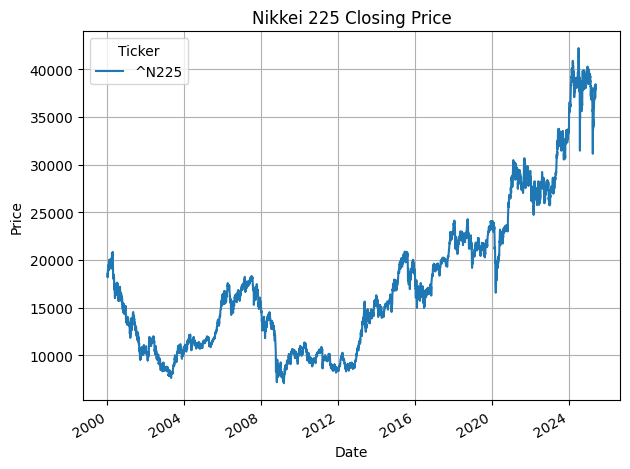

In [23]:
# Price over time
plt.figure(figsize=(14, 4))
df["Price"].plot(title="Nikkei 225 Closing Price", ylabel="Price", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

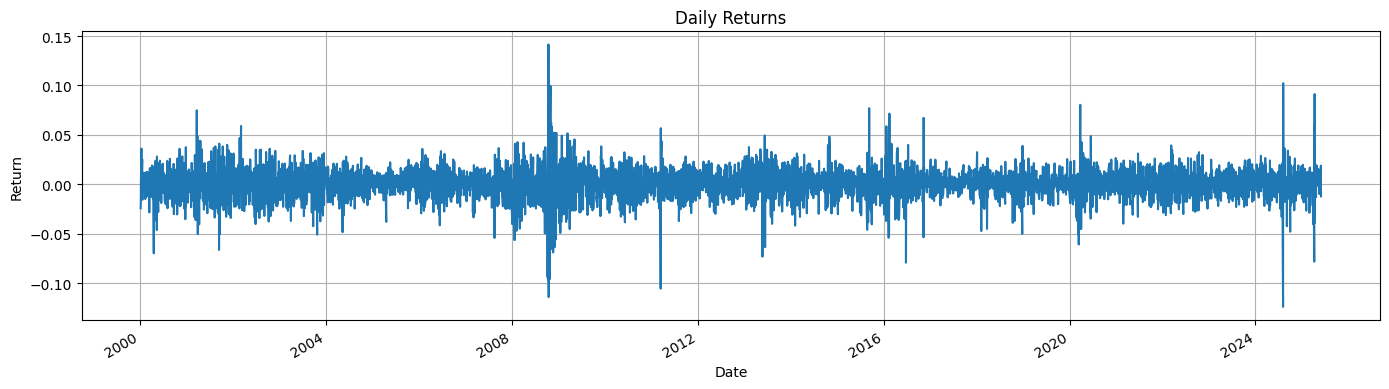

In [24]:
# Daily returns over time
plt.figure(figsize=(14, 4))
df["Return"].plot(title="Daily Returns", ylabel="Return", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

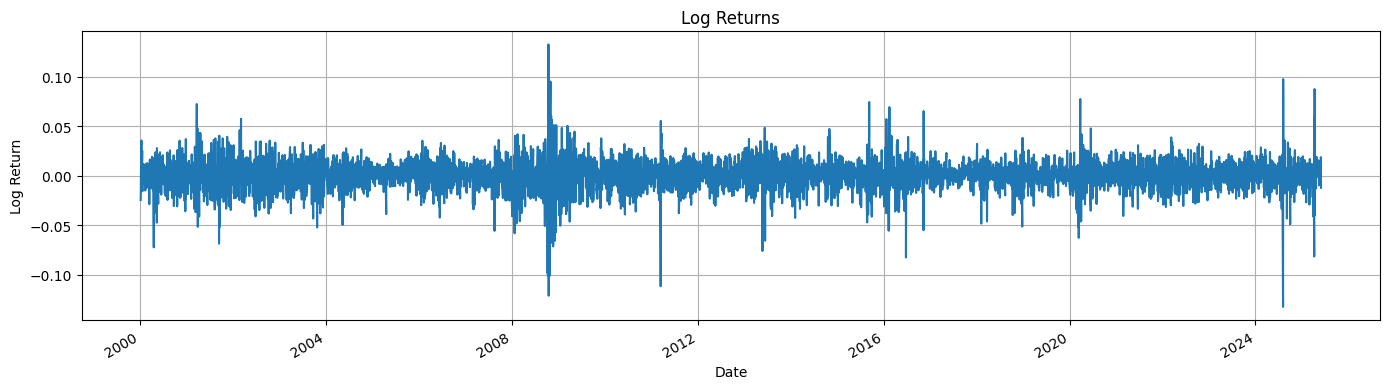

In [25]:
# Log returns over time
plt.figure(figsize=(14, 4))
df["LogReturn"].plot(title="Log Returns", ylabel="Log Return", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

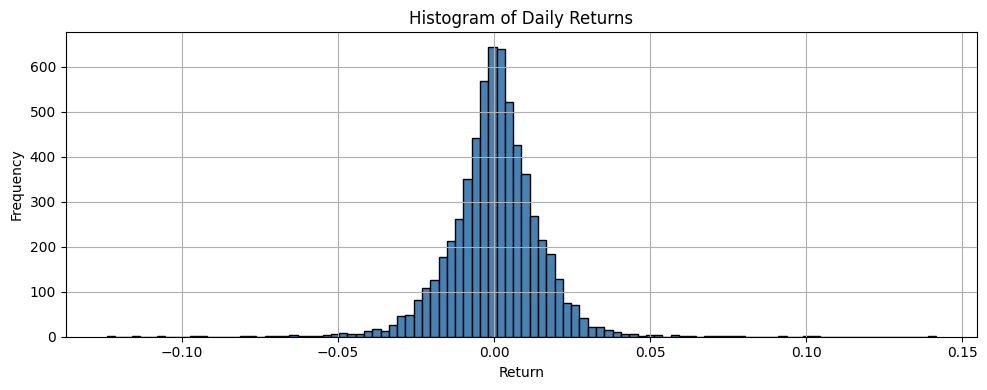

In [26]:
# Histogram of returns
plt.figure(figsize=(10, 4))
plt.hist(df["Return"], bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

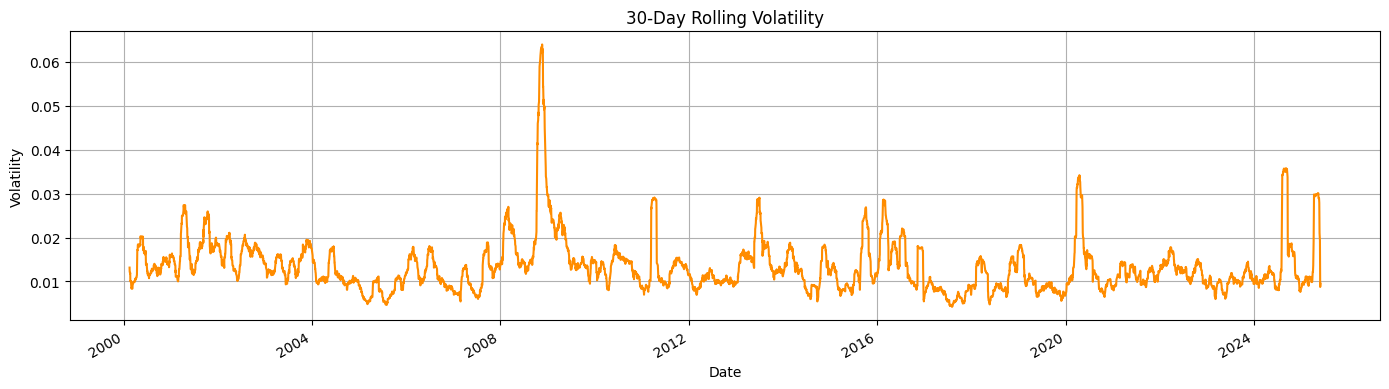

In [27]:
# Rolling volatility (30-day std of returns)
df["Volatility"] = df["Return"].rolling(window=30).std()

plt.figure(figsize=(14, 4))
df["Volatility"].plot(title="30-Day Rolling Volatility", ylabel="Volatility", xlabel="Date", color='darkorange')
plt.grid(True)
plt.tight_layout()
plt.show()

# Models

In [28]:
# Model Evaluation
def evaluate_forecast(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"Evaluation for {model_name}:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return {"model": model_name, "MAE": mae, "RMSE": rmse, "MAPE": mape}

## Benchmark Models

### Naive Forecast

In [ ]:
#Naive model

# If your columns are still multi-indexed, flatten them again (just in case)
df.columns = [col[0] for col in df.columns]

# Recreate the NaiveForecast column
df["NaiveForecast"] = df["Price"].shift(1)

# Recreate the DataFrame used for evaluation
naive_df = df.dropna(subset=["NaiveForecast"])

In [ ]:
# Zoom into recent data
naive_df_zoom = naive_df.loc["2023-01-01":"2025-05-31"]

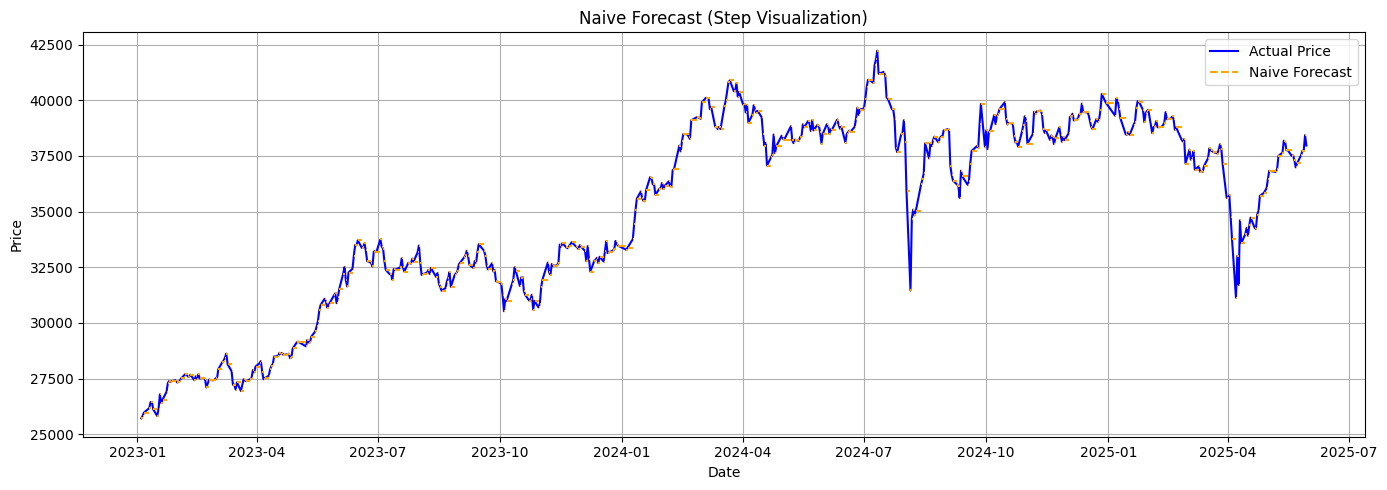

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(naive_df_zoom.index, naive_df_zoom["Price"], label="Actual Price", color="blue")

# Draw horizontal lines for each naive prediction (step-style)
for i in range(1, len(naive_df_zoom)):
    x_vals = [naive_df_zoom.index[i-1], naive_df_zoom.index[i]]
    y_vals = [naive_df_zoom["NaiveForecast"].iloc[i]] * 2
    plt.plot(x_vals, y_vals, color="orange", linestyle="--")

plt.title("Naive Forecast (Step Visualization)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(["Actual Price", "Naive Forecast"])
plt.grid(True)
plt.tight_layout()
plt.show()

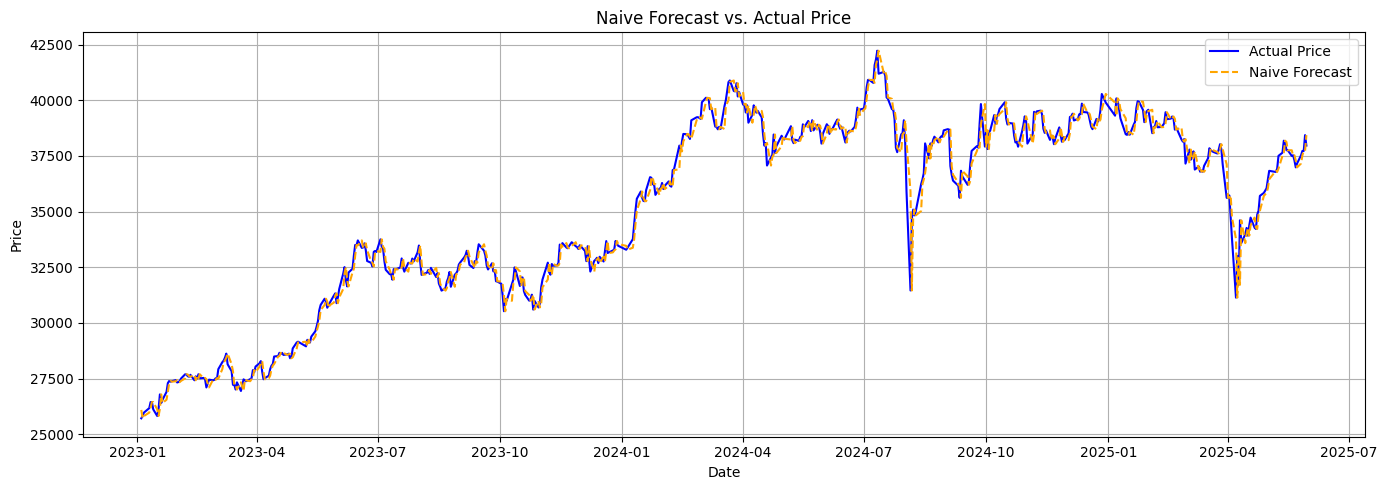

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(naive_df_zoom.index, naive_df_zoom["Price"], label="Actual Price", color="blue")
plt.plot(naive_df_zoom.index, naive_df_zoom["NaiveForecast"], label="Naive Forecast", color="orange", linestyle="--")

plt.title("Naive Forecast vs. Actual Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
results_naive = evaluate_forecast(
    y_true=naive_df["Price"],
    y_pred=naive_df["NaiveForecast"],
    model_name="Naive"
)

Evaluation for Naive:
MAE:  173.18
RMSE: 262.44
MAPE: 1.04%


### SMA

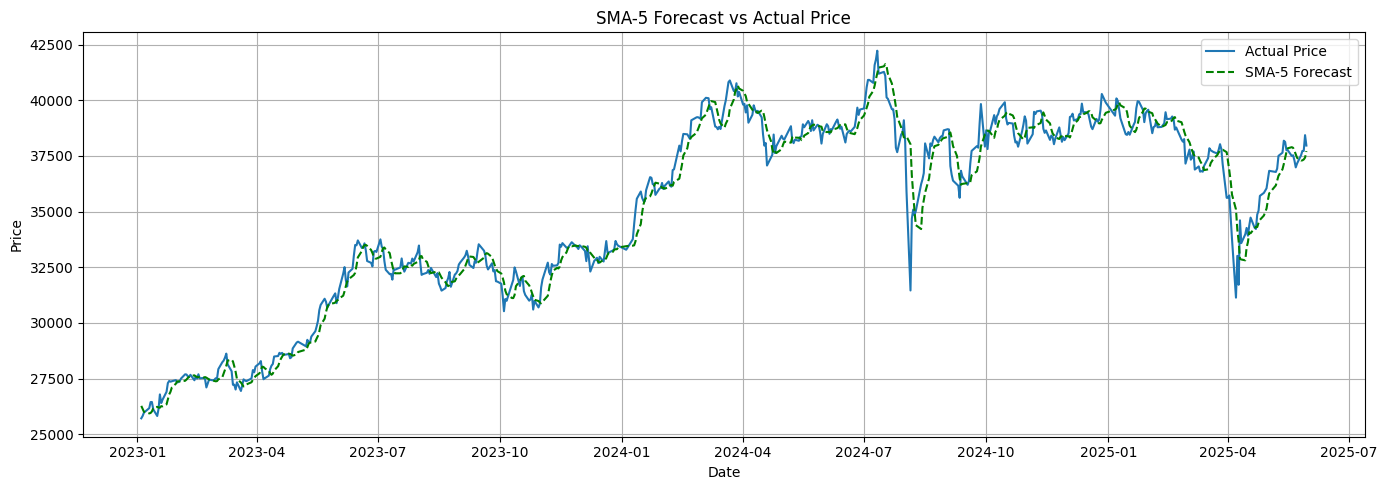

SMA-5 Model MAE: 259.0134
SMA-5 Model RMSE: 377.7869
SMA-3: MAE = 217.38
SMA-5: MAE = 259.01
SMA-10: MAE = 341.01
SMA-20: MAE = 457.67
SMA-30: MAE = 547.26


In [ ]:
# Define SMA window size (e.g., 5 days)
window_size = 5

# SMA forecast: mean of last `window_size` prices
df["SMAForecast"] = df["Price"].shift(1).rolling(window=window_size).mean()

# Drop rows with NaN due to shift and rolling
sma_df = df.dropna(subset=["SMAForecast"])

# Plot actual vs SMA forecast (zoom into recent)
sma_df_zoom = sma_df.loc["2023-01-01":"2025-05-31"]

plt.figure(figsize=(14, 5))
plt.plot(sma_df_zoom.index, sma_df_zoom["Price"], label="Actual Price")
plt.plot(sma_df_zoom.index, sma_df_zoom["SMAForecast"], label=f"SMA-{window_size} Forecast", linestyle="--", color="green")
plt.title(f"SMA-{window_size} Forecast vs Actual Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sma = mean_absolute_error(sma_df["Price"], sma_df["SMAForecast"])
rmse_sma = np.sqrt(mean_squared_error(sma_df["Price"], sma_df["SMAForecast"]))

print(f"SMA-{window_size} Model MAE: {mae_sma:.4f}")
print(f"SMA-{window_size} Model RMSE: {rmse_sma:.4f}")

for window_size in [3, 5, 10, 20, 30]:
    forecast = df["Price"].shift(1).rolling(window=window_size).mean()
    valid = df[~forecast.isna()]
    mae = mean_absolute_error(valid["Price"], forecast.dropna())
    print(f"SMA-{window_size}: MAE = {mae:.2f}")

In [ ]:
# Evaluate
results_sma = evaluate_forecast(
    y_true=sma_df["Price"],
    y_pred=sma_df["SMAForecast"],
    model_name="SMA"
)

Evaluation for SMA:
MAE:  259.01
RMSE: 377.79
MAPE: 1.55%


## Classical Models

### Holt-Winters

In [ ]:
!pip install statsmodels

from statsmodels.tsa.holtwinters import ExponentialSmoothing

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = PipSession(
              ^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
# # Ensure index is datetime and data is at a regular frequency
# df = df.asfreq('B')  # Business days (adjust if needed)
# df["Price"] = df["Price"].ffill()

# # Pick recent data for faster model training
# train_data = df["Price"].loc["2018-01-01":"2024-12-31"]

# # Choose seasonal period (e.g., 252 for yearly if daily data, 5 for weekly)
# seasonal_period = 252

# # 🔹 ADDITIVE Holt-Winters model
# model_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=seasonal_period)
# fit_add = model_add.fit()

# # 🔹 MULTIPLICATIVE Holt-Winters model
# model_mul = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=seasonal_period)
# fit_mul = model_mul.fit()

# # Forecast next N days
# forecast_horizon = 90
# forecast_add = fit_add.forecast(forecast_horizon)
# forecast_mul = fit_mul.forecast(forecast_horizon)

# plt.figure(figsize=(16, 6))

# # Additive
# plt.plot(train_data.index, train_data, label='Train')
# plt.plot(forecast_add.index, forecast_add, label='Additive Forecast', linestyle='--', color='green')

# # Multiplicative
# plt.plot(forecast_mul.index, forecast_mul, label='Multiplicative Forecast', linestyle='--', color='orange')

# plt.title("Holt-Winters Forecast (Additive vs Multiplicative)")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Assuming actual test data exists
# test_data = df["Price"].loc["2025-01-01":"2025-05-31"]

# from sklearn.metrics import mean_absolute_error, mean_squared_error

# mae_add = mean_absolute_error(test_data[:len(forecast_add)], forecast_add)
# mae_mul = mean_absolute_error(test_data[:len(forecast_mul)], forecast_mul)

# print(f"Additive MAE: {mae_add:.2f}")
# print(f"Multiplicative MAE: {mae_mul:.2f}")

In [ ]:
# Ensure index is datetime and data is at a regular frequency
df = df.asfreq('B')  # Business days (adjust if needed)
df["Price"] = df["Price"].ffill()

# Pick recent data for faster model training
train_data = df["Price"].loc["2003-01-01":"2022-12-31"]

# Choose seasonal period (e.g., 252 for yearly if daily data, 5 for weekly)
seasonal_period = 252

# 🔹 ADDITIVE Holt-Winters model
model_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=seasonal_period)
fit_add = model_add.fit()

# 🔹 MULTIPLICATIVE Holt-Winters model
model_mul = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=seasonal_period)
fit_mul = model_mul.fit()

# Forecast next N days
forecast_horizon = df.loc["2023-01-01":"2025-05-30"].shape[0]
forecast_add = fit_add.forecast(forecast_horizon)
forecast_mul = fit_mul.forecast(forecast_horizon)

In [ ]:
test_data_subset = df["Price"].loc[forecast_add.index]

# Define zoom range
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"

# Actual price in zoom range
actual_zoom = df["Price"].loc[zoom_start:zoom_end]

# Filter forecasts to the same range (align indices)
forecast_add_zoom = forecast_add.loc[zoom_start:zoom_end]
forecast_mul_zoom = forecast_mul.loc[zoom_start:zoom_end]

# Plot
plt.figure(figsize=(16, 6))
plt.plot(actual_zoom.index, actual_zoom, label="Actual Price", color="black")
plt.plot(forecast_add_zoom.index, forecast_add_zoom, label="Holt-Winters Additive", linestyle='--', color="green")
plt.plot(forecast_mul_zoom.index, forecast_mul_zoom, label="Holt-Winters Multiplicative", linestyle='--', color="orange")
plt.title("Holt-Winters Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# # Assuming actual test data exists
# test_data = df["Price"].loc["2023-01-01":"2025-05-30"]

# from sklearn.metrics import mean_absolute_error, mean_squared_error

# mae_add = mean_absolute_error(test_data_subset, forecast_add)
# mae_mul = mean_absolute_error(test_data_subset, forecast_mul)

# rmse_add = mean_squared_error(test_data_subset, forecast_add)
# rmse_mul = mean_squared_error(test_data_subset, forecast_mul)

# print(f"Additive MAE: {mae_add:.2f}, RMSE: {rmse_add:.2f}")
# print(f"Multiplicative MAE: {mae_mul:.2f}, RMSE: {rmse_mul:.2f}")

In [ ]:
# Evaluate
results_hw_add = evaluate_forecast(
    y_true=test_data_subset,
    y_pred=forecast_add,
    model_name="Holt-Winters Additive"
)

results_hw_mul = evaluate_forecast(
    y_true=test_data_subset,
    y_pred=forecast_mul,
    model_name="Holt-Winters Multiplicative"
)

### ARIMA

In [ ]:
# V1

# # # -*- coding: utf-8 -*-
# # """tsf_dataPreprocessing.ipynb

# # Automatically generated by Colab.

# # Original file is located at
# #     https://colab.research.google.com/drive/14iThCJk1_Qaw6aj0LS0tl4TDarHDEdTq
# # """

# # =============================
# # Nikkei 225 Benchmark Models
# # =============================

# Step 1: Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 2: Download Data
nikkei = yf.download('^N225', start='2000-01-01', end='2025-05-31')
nikkei = nikkei[['Close']]
nikkei.rename(columns={'Close': 'Price'}, inplace=True)

# Step 3: Calculate Returns
nikkei['Return'] = nikkei['Price'].pct_change()
nikkei.dropna(inplace=True)

# Step 4: Handle Missing Values
nikkei.fillna(method='ffill', inplace=True)

# Step 5: Plot Raw Data
plt.figure(figsize=(12, 6))
plt.plot(nikkei['Price'])
plt.title('Nikkei 225 Closing Prices')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(nikkei['Return'])
plt.title('Nikkei 225 Daily Returns')
plt.show()

# Step 6: Benchmark Models
# 6.1 Naïve Forecast
nikkei['Naive_Price'] = nikkei['Price'].shift(1)

# 6.2 Simple Moving Average (SMA)
window_size = 5
nikkei['SMA_Price'] = nikkei['Price'].rolling(window=window_size).mean()

# 6.3 Exponentially Weighted Moving Average (EWMA)
alpha = 0.3
nikkei['EWMA_Price'] = nikkei['Price'].ewm(alpha=alpha, adjust=False).mean()

# Step 7: Drop NaN Values from Benchmark Models
nikkei.dropna(inplace=True)

# Step 8: Evaluation Function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# Step 9: Calculate Errors for Benchmark Models
rmse_naive, mae_naive = evaluate(nikkei['Price'], nikkei['Naive_Price'])
rmse_sma, mae_sma = evaluate(nikkei['Price'], nikkei['SMA_Price'])
rmse_ewma, mae_ewma = evaluate(nikkei['Price'], nikkei['EWMA_Price'])

# Step 10: Print Benchmark Results
print('Naïve Forecast - RMSE:', rmse_naive, 'MAE:', mae_naive)
print('SMA Forecast - RMSE:', rmse_sma, 'MAE:', mae_sma)
print('EWMA Forecast - RMSE:', rmse_ewma, 'MAE:', mae_ewma)

# Step 11: Plot Benchmark Forecasts vs Actual
plt.figure(figsize=(15, 7))
plt.plot(nikkei['Price'], label='Actual Price', color='black')
plt.plot(nikkei['Naive_Price'], label='Naïve Forecast', linestyle='--')
plt.plot(nikkei['SMA_Price'], label='SMA Forecast', linestyle='--')
plt.plot(nikkei['EWMA_Price'], label='EWMA Forecast', linestyle='--')
plt.legend()
plt.title('Benchmark Model Forecasts vs Actual Price')
plt.show()

# Step 12: ARIMA Preprocessing - Differencing
nikkei['Diff'] = nikkei['Price'].diff()
nikkei.dropna(inplace=True)

# Step 13: Plot ACF and PACF for ARIMA Order Selection
plot_acf(nikkei['Diff'], lags=30)
plt.show()

plot_pacf(nikkei['Diff'], lags=30)
plt.show()

# Step 14: ARIMA Forecasting (Example with order (1,1,1))
model = ARIMA(nikkei['Price'], order=(1, 1, 1))
model_fit = model.fit()

# Step 15: Forecast Next 7 Days
forecast = model_fit.forecast(steps=265)

# Step 16: Plot ARIMA Forecast vs Actual
plt.figure(figsize=(15, 7))
plt.plot(nikkei['Price'], label='Actual Price', color='white')
plt.plot(forecast.index, forecast, label='ARIMA Forecast (Next 7 Days)', linestyle='--')
plt.legend()
plt.title('ARIMA Forecast vs Actual Price')
plt.show()

# Step 17: Print Forecasted Prices
print('7-Day ARIMA Forecast:')
print(forecast)

In [ ]:
# V2 (by Rakko)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure datetime index and handle missing data
# df = df.asfreq("B")
# df["Price"] = df["Price"].ffill()

# --- 1. Split Data ---
arima_train_data = df["Price"].loc["2003-01-01":"2022-12-31"]
arima_test_data = df["Price"].loc["2023-01-01":"2025-05-30"]

# --- 2. Fit ARIMA Model ---
# You can change order=(p,d,q) if needed (currently (1,1,1) as a basic starting point)
arima_model = ARIMA(arima_train_data, order=(5, 1, 1))
arima_model_fit = arima_model.fit()

# --- 3. Forecast ---
forecast_horizon = len(arima_test_data)
forecast_arima = arima_model_fit.forecast(steps=forecast_horizon)
forecast_arima.index = arima_test_data.index  # align index for plotting and comparison

# --- 4. Evaluate ---
# mae_arima = mean_absolute_error(test_data, forecast_arima)
# rmse_arima = mean_squared_error(test_data, forecast_arima, squared=False)

# print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")

# --- 5. Plot (Zoomed like other models) ---
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"
actual_zoom = arima_test_data.loc[zoom_start:zoom_end]
forecast_arima_zoom = forecast_arima.loc[zoom_start:zoom_end]

plt.figure(figsize=(16, 6))
plt.plot(actual_zoom.index, actual_zoom, label="Actual Price", color="black")
plt.plot(forecast_arima_zoom.index, forecast_arima_zoom, label="ARIMA Forecast", linestyle="--", color="purple")
plt.title("ARIMA Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### V3

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

Final columns: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

ARIMA RMSE: 9853.56, MAE: 8928.54
ARIMAX RMSE: 9895.31, MAE: 8973.91
SARIMAX RMSE: 9875.12, MAE: 8954.13


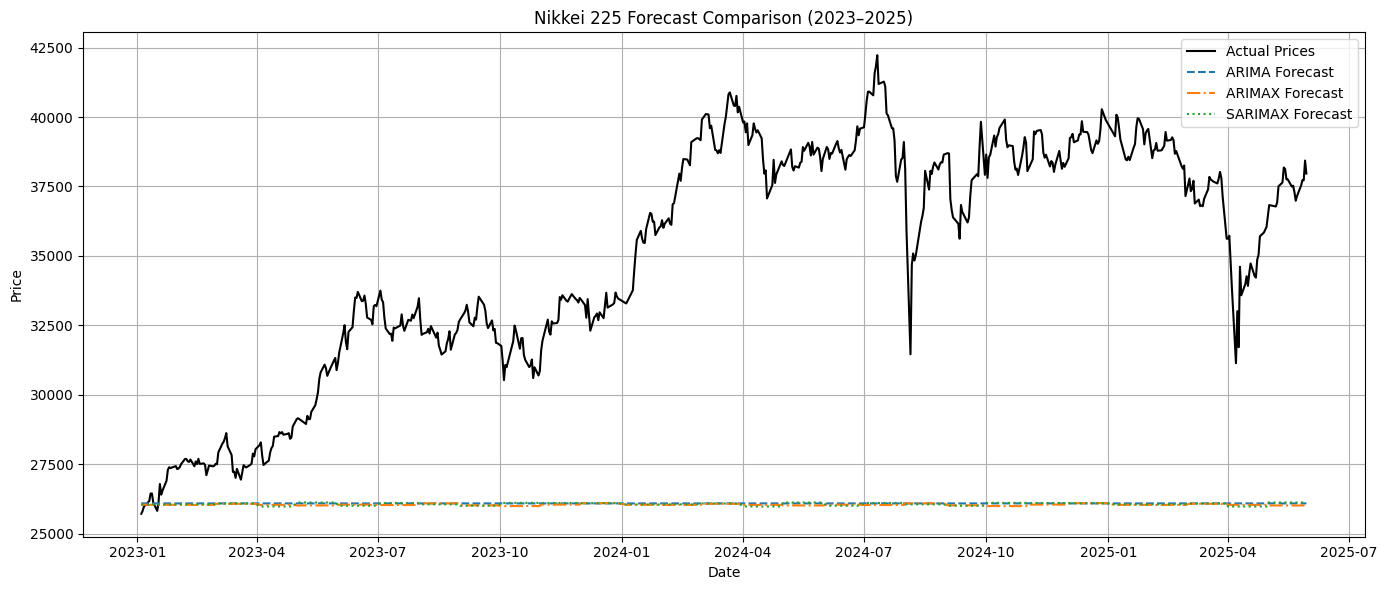

In [32]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Load real Nikkei 225 data
nikkei = yf.download("^N225", start="2000-01-01", end="2025-05-31", auto_adjust=False)
nikkei.columns = nikkei.columns.droplevel(1)
print("Final columns:", nikkei.columns)
if 'Close' not in nikkei.columns:
    raise ValueError("Expected 'Close' column not found in downloaded data.")
nikkei = nikkei[['Close']]
nikkei['Return'] = nikkei['Close'].pct_change()
nikkei['month'] = nikkei.index.month
month_dummies = pd.get_dummies(nikkei['month'], prefix='month', drop_first=True)
nikkei = pd.concat([nikkei, month_dummies], axis=1)
nikkei.dropna(inplace=True)

# Step 2: Split data
train = nikkei['Close'][:'2022']
test = nikkei['Close']['2023':]
train_exog = nikkei.loc[:'2022', month_dummies.columns]
test_exog = nikkei.loc['2023':, month_dummies.columns]
actual_prices = test.copy()

# Step 3: ARIMA
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_forecast_price = arima_result.forecast(steps=len(test))

# Step 4: ARIMAX
arimax_model = ARIMA(train, order=(1, 1, 1), exog=train_exog)
arimax_result = arimax_model.fit()
arimax_forecast_price = arimax_result.forecast(steps=len(test), exog=test_exog)

# Step 5: SARIMAX
sarimax_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), exog=train_exog)
sarimax_result = sarimax_model.fit()
sarimax_forecast_price = sarimax_result.forecast(steps=len(test), exog=test_exog)

# Step 6: Metrics
arima_rmse = np.sqrt(mean_squared_error(actual_prices.to_numpy(), arima_forecast_price.to_numpy()))
arimax_rmse = np.sqrt(mean_squared_error(actual_prices.to_numpy(), arimax_forecast_price.to_numpy()))
sarimax_rmse = np.sqrt(mean_squared_error(actual_prices.to_numpy(), sarimax_forecast_price.to_numpy()))

arima_mae = mean_absolute_error(actual_prices.to_numpy(), arima_forecast_price.to_numpy())
arimax_mae = mean_absolute_error(actual_prices.to_numpy(), arimax_forecast_price.to_numpy())
sarimax_mae = mean_absolute_error(actual_prices.to_numpy(), sarimax_forecast_price.to_numpy())

print(f"ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"ARIMAX RMSE: {arimax_rmse:.2f}, MAE: {arimax_mae:.2f}")
print(f"SARIMAX RMSE: {sarimax_rmse:.2f}, MAE: {sarimax_mae:.2f}")

# Step 7: Plot
plt.figure(figsize=(14, 6))
plt.plot(actual_prices.index, actual_prices, label='Actual Prices', color='black')
plt.plot(actual_prices.index, arima_forecast_price, label='ARIMA Forecast', linestyle='--')
plt.plot(actual_prices.index, arimax_forecast_price, label='ARIMAX Forecast', linestyle='-.')
plt.plot(actual_prices.index, sarimax_forecast_price, label='SARIMAX Forecast', linestyle=':')
plt.title('Nikkei 225 Forecast Comparison (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### V3 Modded

In [29]:
df.head()

Price,Price,Return,LogPrice,LogReturn,Volatility
Ticker,^N225,,,,
Date,,,,,
2000-01-05,18542.550781,-0.024223,9.827823,-0.024521,NaN
2000-01-06,18168.269531,-0.020185,9.807432,-0.020391,NaN
2000-01-07,18193.410156,0.001384,9.808815,0.001383,NaN
2000-01-11,18850.919922,0.036140,9.844317,0.035502,NaN
2000-01-12,18677.419922,-0.009204,9.835071,-0.009246,NaN


In [31]:
train

,LogPrice
Date,
2000-01-05,9.827823
2000-01-06,9.807432
2000-01-07,9.808815
2000-01-11,9.844317
2000-01-12,9.835071
...,...
2022-12-26,10.181342
2022-12-27,10.182931
2022-12-28,10.178863


In [35]:
arima_forecast_price.head()

,predicted_mean
5634,10.169387
5635,10.169425
5636,10.169410
5637,10.169416
5638,10.169413


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA   RMSE: 9396.54, MAE: 8513.54
ARIMAX  RMSE: 10182.40, MAE: 9276.57
SARIMAX RMSE: 8977.91, MAE: 8142.75


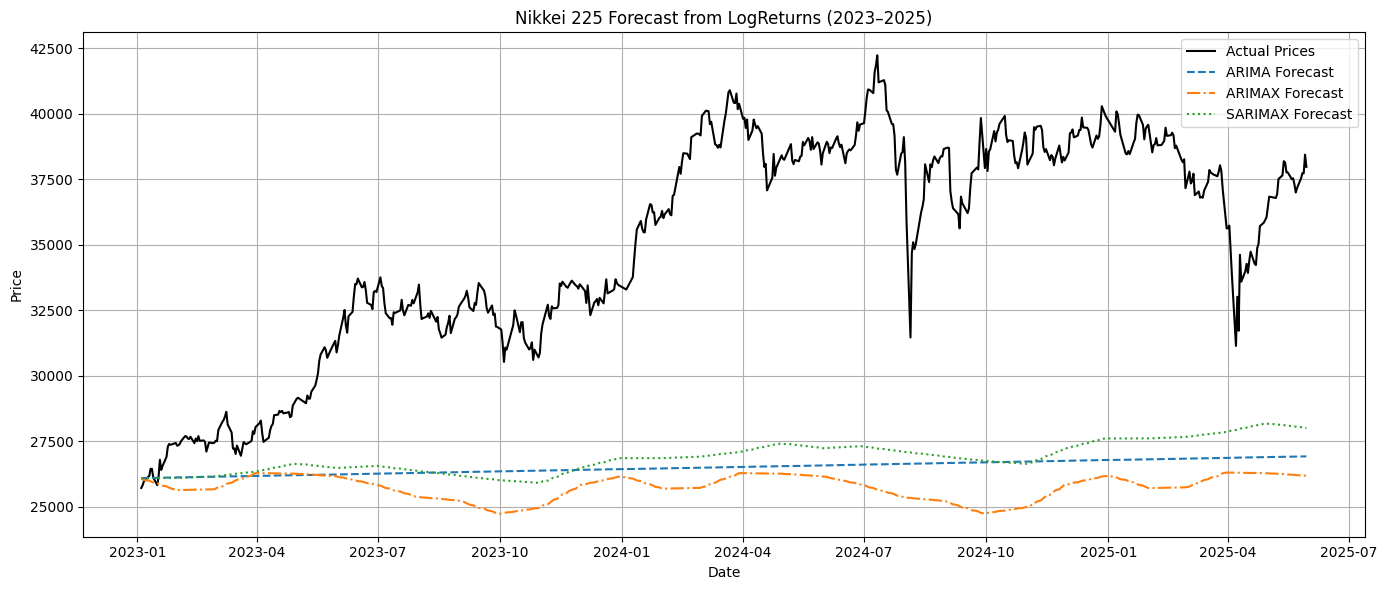

In [39]:
# # V3
# import yfinance as yf
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Step 1: Load real Nikkei 225 data
# nikkei = yf.download("^N225", start="2000-01-01", end="2025-05-31", auto_adjust=False)
# nikkei.columns = nikkei.columns.droplevel(1)
# print("Final columns:", nikkei.columns)
# if 'Close' not in nikkei.columns:
#     raise ValueError("Expected 'Close' column not found in downloaded data.")
# nikkei = nikkei[['Close']]
# nikkei['Return'] = nikkei['Close'].pct_change()
# nikkei['month'] = nikkei.index.month
# month_dummies = pd.get_dummies(nikkei['month'], prefix='month', drop_first=True)
# nikkei = pd.concat([nikkei, month_dummies], axis=1)
# nikkei.dropna(inplace=True)

# # Step 2: Split data
# train = nikkei['Close'][:'2022']
# test = nikkei['Close']['2023':]
# train_exog = nikkei.loc[:'2022', month_dummies.columns]
# test_exog = nikkei.loc['2023':, month_dummies.columns]
# actual_prices = test.copy()

# df.dropna(inplace=True)

# # Add month dummies as exogenous features
df["month"] = df.index.month
month_dummies = pd.get_dummies(df["month"], prefix="month", drop_first=True)
month_dummies = month_dummies.astype(int)
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
df = pd.concat([df, month_dummies], axis=1)

# STEP 2: Use LogReturn as target
train = df["LogReturn"][:'2022']
test = df["LogReturn"]['2023':]
train_exog = df.loc[:'2022', month_dummies.columns]
test_exog = df.loc['2023':, month_dummies.columns]
actual_prices = np.exp(test)  # convert log-prices back to prices for evaluation
last_train_price = df.loc[train.index[-1], "Price"]

train = train.astype(float)
test = test.astype(float)
train_exog = train_exog.astype(float)
test_exog = test_exog.astype(float)

# Step 3: ARIMA
arima_model = ARIMA(train, order=(1, 0, 1))  # no differencing since LogReturn is already diffed
arima_result = arima_model.fit()
arima_log_returns = arima_result.forecast(steps=len(test))

# Step 4: ARIMAX
arimax_model = ARIMA(train, order=(1, 0, 1), exog=train_exog)
arimax_result = arimax_model.fit()
arimax_log_returns = arimax_result.forecast(steps=len(test), exog=test_exog)

# Step 5: SARIMAX
sarimax_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12), exog=train_exog)
sarimax_result = sarimax_model.fit()
sarimax_log_returns = sarimax_result.forecast(steps=len(test), exog=test_exog)

# STEP 6: Reconstruct prices from predicted log returns
def reconstruct_prices(log_returns, start_price):
    cumulative = np.exp(np.cumsum(log_returns))
    return start_price * cumulative

actual_prices = df["Price"]['2023':]
arima_prices = reconstruct_prices(arima_log_returns, last_train_price)
arimax_prices = reconstruct_prices(arimax_log_returns, last_train_price)
sarimax_prices = reconstruct_prices(sarimax_log_returns, last_train_price)

# Step 6: Metrics
arima_rmse = np.sqrt(mean_squared_error(actual_prices, arima_prices))
arimax_rmse = np.sqrt(mean_squared_error(actual_prices, arimax_prices))
sarimax_rmse = np.sqrt(mean_squared_error(actual_prices, sarimax_prices))

arima_mae = mean_absolute_error(actual_prices, arima_prices)
arimax_mae = mean_absolute_error(actual_prices, arimax_prices)
sarimax_mae = mean_absolute_error(actual_prices, sarimax_prices)

print(f"ARIMA   RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"ARIMAX  RMSE: {arimax_rmse:.2f}, MAE: {arimax_mae:.2f}")
print(f"SARIMAX RMSE: {sarimax_rmse:.2f}, MAE: {sarimax_mae:.2f}")

# Step 7: Plot
plt.figure(figsize=(14, 6))
plt.plot(actual_prices.index, actual_prices.values, label='Actual Prices', color='black')
plt.plot(actual_prices.index, arima_prices, label='ARIMA Forecast', linestyle='--')
plt.plot(actual_prices.index, arimax_prices, label='ARIMAX Forecast', linestyle='-.')
plt.plot(actual_prices.index, sarimax_prices, label='SARIMAX Forecast', linestyle=':')
plt.title('Nikkei 225 Forecast from LogReturns (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Advanced Models

### Prophet (Meta)

In [ ]:
# from prophet import Prophet

# # Prepare the DataFrame for Prophet
# prophet_df = df.reset_index()
# prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Price': 'y'})

# # Flatten the column index
# prophet_df.columns = prophet_df.columns.get_level_values(0)

# # Initialize and fit the Prophet model
# model = Prophet(
#     yearly_seasonality=True,
#     weekly_seasonality=True,
#     daily_seasonality=False  # Set to True if you have daily data and want to model daily seasonality
# )
# model.fit(prophet_df)

# # Create a DataFrame for future predictions (e.g., next 365 days)
# future = model.make_future_dataframe(periods=365)

# # Make predictions
# forecast = model.predict(future)

In [ ]:
from prophet import Prophet

# Prepare the DataFrame for Prophet
prophet_df = df.reset_index()
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Price': 'y'})

# Train-test split
train_prophet = prophet_df[(prophet_df['ds'] >= '2003-01-01') & (prophet_df['ds'] <= '2022-12-31')]
test_prophet = prophet_df[(prophet_df['ds'] >= '2023-01-01') & (prophet_df['ds'] <= '2025-05-30')]
# Flatten the column index
train_prophet.columns = train_prophet.columns.get_level_values(0)

# Initialize and fit the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(train_prophet)

# Forecast length = test period length
forecast_horizon = test_prophet.shape[0]

# Make future dataframe for prediction
future = model.make_future_dataframe(periods=forecast_horizon, freq='B')
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprw3kff4d/249ydtld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprw3kff4d/5px2qs_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92761', 'data', 'file=/tmp/tmprw3kff4d/249ydtld.json', 'init=/tmp/tmprw3kff4d/5px2qs_k.json', 'output', 'file=/tmp/tmprw3kff4d/prophet_modeldhhbe6ub/prophet_model-20250708073159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:31:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# # Display the first few rows of the forecast
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# # Plot the forecast
# fig = model.plot(forecast)
# plt.title("Nikkei 225 Price Forecast with Prophet")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.show()

# # Plot components of the forecast
# fig2 = model.plot_components(forecast)
# plt.show()

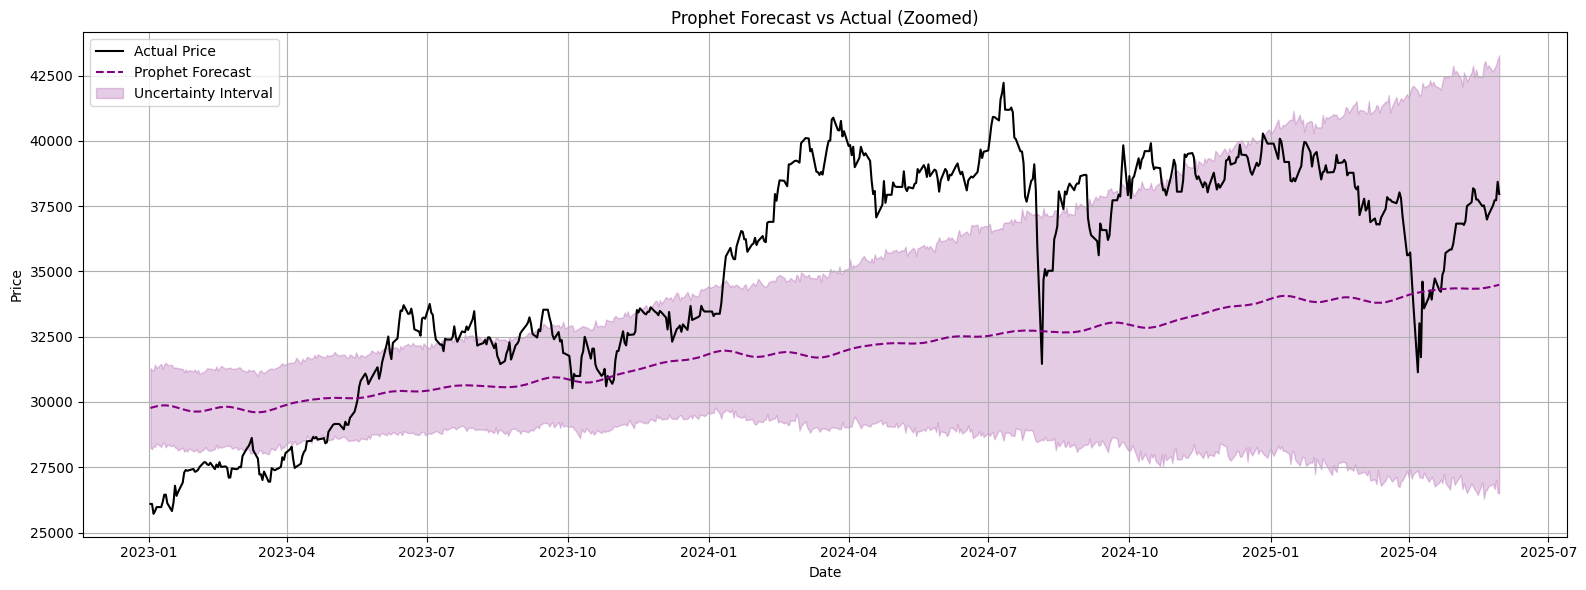

In [ ]:
# Extract only the forecasted range (match test data)
forecast_subset = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2025-05-30')]

# Zoomed Plot: Forecast vs Actual
plt.figure(figsize=(16, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label="Actual Price", color="black")
plt.plot(forecast_subset['ds'], forecast_subset['yhat'], label="Prophet Forecast", linestyle='--', color="purple")
plt.fill_between(forecast_subset['ds'], forecast_subset['yhat_lower'], forecast_subset['yhat_upper'], color="purple", alpha=0.2, label="Uncertainty Interval")
plt.title("Prophet Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate

y_true = test_prophet['y'].values
y_pred = forecast_subset['yhat'].values

results_prophet = evaluate_forecast(
    y_true,
    y_pred,
    model_name="Prophet"
)

Evaluation for Prophet:
MAE:  3751.73
RMSE: 4376.88
MAPE: 10.27%


### N-BEATS

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn

# # 2. Create sliding windows for supervised learning
# class TimeSeriesDataset(Dataset):
#     def __init__(self, series, backcast_length, forecast_length):
#         self.X = []
#         self.y = []
#         for i in range(backcast_length, len(series) - forecast_length):
#             self.X.append(series[i - backcast_length:i])
#             self.y.append(series[i:i + forecast_length])
#         self.X = torch.tensor(self.X, dtype=torch.float32)
#         self.y = torch.tensor(self.y, dtype=torch.float32)

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# log_returns = df["LogReturn"].values
# backcast_length = 30
# forecast_length = 7
# dataset = TimeSeriesDataset(log_returns, backcast_length, forecast_length)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# # N-BEATS Block
# class NBeatsBlock(nn.Module):
#     def __init__(self, input_size, theta_size, hidden_size, n_layers, backcast_length, forecast_length):
#         super().__init__()
#         self.hidden = nn.ModuleList([
#             nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(n_layers)
#         ])
#         self.relu = nn.ReLU()
#         self.theta = nn.Linear(hidden_size, theta_size)
#         self.backcast_proj = nn.Linear(theta_size, backcast_length)
#         self.forecast_proj = nn.Linear(theta_size, forecast_length)

#     def forward(self, x):
#         for layer in self.hidden:
#             x = self.relu(layer(x))
#         theta = self.theta(x)
#         backcast = self.backcast_proj(theta)
#         forecast = self.forecast_proj(theta)
#         return backcast, forecast

# # N-BEATS Model
# class NBeats(nn.Module):
#     def __init__(self, input_size, backcast_length, forecast_length,
#                  n_blocks=3, hidden_size=128, n_layers=4, theta_size=256):
#         super().__init__()
#         self.blocks = nn.ModuleList([
#             NBeatsBlock(input_size, theta_size, hidden_size, n_layers,
#                         backcast_length, forecast_length) for _ in range(n_blocks)
#         ])

#     def forward(self, x):
#         residual = x
#         forecast = 0
#         for block in self.blocks:
#             backcast, block_forecast = block(residual)
#             residual = residual - backcast
#             forecast = forecast + block_forecast
#         return forecast

In [ ]:
# # 5. Train the model
# model = NBeats(
#     input_size=backcast_length,
#     backcast_length=backcast_length,
#     forecast_length=forecast_length
# )

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# epochs = 10
# model.train()
# for epoch in range(epochs):
#     total_loss = 0
#     for X_batch, y_batch in dataloader:
#         optimizer.zero_grad()
#         output = model(X_batch)
#         loss = criterion(output, y_batch)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.6f}")

In [ ]:
# # Switch to eval mode
# model.eval()

# # Take one batch for visualization
# with torch.no_grad():
#     X_sample, y_true = next(iter(dataloader))
#     y_pred = model(X_sample)

# # Plot the first sample from the batch
# idx = 0
# plt.figure(figsize=(10, 4))
# plt.plot(range(backcast_length), X_sample[idx].numpy(), label="Input (Backcast)", color='blue')
# plt.plot(range(backcast_length, backcast_length + forecast_length),
#          y_true[idx].numpy(), label="Actual (Forecast)", color='green')
# plt.plot(range(backcast_length, backcast_length + forecast_length),
#          y_pred[idx].numpy(), label="Predicted", color='red', linestyle='--')
# plt.title("N-BEATS Forecast Visualization")
# plt.xlabel("Time Steps")
# plt.ylabel("Log Return")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

#### Modded V1

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Set random seed
# torch.manual_seed(42)
# np.random.seed(42)

# # Prepare Data
# df = df.asfreq("B")
# df["Price"] = df["Price"].ffill()
# df["LogReturn"] = np.log(df["Price"] / df["Price"].shift(1))
df["LogReturn"] = df["LogReturn"].fillna(0)

train_log_returns = df.loc["2003-01-01":"2022-12-31", "LogReturn"].values
test_data = df["Price"].loc["2023-01-01":"2025-05-30"]
test_log_returns = df["LogReturn"].loc["2023-01-01":"2025-05-30"]
test_dates = test_log_returns.index
last_train_price = df.loc["2022-12-30", "Price"]  # last known price before test

# Define Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, series, backcast_length, forecast_length):
        self.X = []
        self.y = []
        for i in range(backcast_length, len(series) - forecast_length):
            self.X.append(series[i - backcast_length:i])
            self.y.append(series[i:i + forecast_length])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

backcast_length = 30
forecast_length = 7

train_dataset = TimeSeriesDataset(train_log_returns, backcast_length, forecast_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define N-BEATS Model
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_size, n_layers, backcast_length, forecast_length):
        super().__init__()
        self.hidden = nn.ModuleList([
            nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(n_layers)
        ])
        self.relu = nn.ReLU()
        self.theta = nn.Linear(hidden_size, theta_size)
        self.backcast_proj = nn.Linear(theta_size, backcast_length)
        self.forecast_proj = nn.Linear(theta_size, forecast_length)

    def forward(self, x):
        for layer in self.hidden:
            x = self.relu(layer(x))
        theta = self.theta(x)
        backcast = self.backcast_proj(theta)
        forecast = self.forecast_proj(theta)
        return backcast, forecast

class NBeats(nn.Module):
    def __init__(self, input_size, backcast_length, forecast_length,
                 n_blocks=3, hidden_size=128, n_layers=4, theta_size=256):
        super().__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, theta_size, hidden_size, n_layers,
                        backcast_length, forecast_length) for _ in range(n_blocks)
        ])

    def forward(self, x):
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

/tmp/ipython-input-13-3419489246.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.X = torch.tensor(self.X, dtype=torch.float32)


In [ ]:
# Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(
    input_size=backcast_length,
    backcast_length=backcast_length,
    forecast_length=forecast_length
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("Total Loss:", total_loss)
    print("y_batch stats — min:", y_batch.min().item(), "max:", y_batch.max().item(), "mean:", y_batch.mean().item())
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.6f}")

# Recursive Forecast on Test Set
model.eval()
input_window = torch.tensor(train_log_returns[-backcast_length:], dtype=torch.float32).to(device)
predicted_returns = []

predicted_returns = []
steps = len(test_log_returns)

with torch.no_grad():
    input_seq = input_window.clone()
    for _ in range(0, steps, forecast_length):
        forecast = model(input_seq.unsqueeze(0)).squeeze(0).cpu().numpy()
        take = min(forecast_length, steps - len(predicted_returns))
        predicted_returns.extend(forecast[:take])
        input_seq = torch.cat([
            input_seq[forecast_length:],
            torch.tensor(forecast[:take], dtype=torch.float32).to(device)
        ])

# Compute predicted prices
predicted_returns = np.array(predicted_returns)
cumulative_returns = np.cumprod(1 + predicted_returns)
last_train_price_value = float(last_train_price)  # ensure scalar
predicted_prices = last_train_price_value * cumulative_returns

print("Len predicted_returns:", len(predicted_returns))
print("Len cumulative_returns:", len(cumulative_returns))
print("Len test_dates:", len(test_dates))
print("Shape test_dates:", test_dates.shape)
print("Last train price:", last_train_price.shape)

# Make sure test_dates is an Index of length 630
predicted_prices = pd.Series(predicted_prices, index=test_dates)  # This must succeed
actual_prices = df.loc["2023-01-01":"2025-05-30", "Price"].values

Total Loss: 0.047371555599966086
y_batch stats — min: -0.04965471103787422 max: 0.041823334991931915 mean: 0.0010731210932135582
Epoch 1/50 - Loss: 0.000312
Total Loss: 0.035843753881636076
y_batch stats — min: -0.041321855038404465 max: 0.027455473318696022 mean: 0.0008275224245153368
Epoch 2/50 - Loss: 0.000236
Total Loss: 0.03693428357655648
y_batch stats — min: -0.04815726727247238 max: 0.06508316099643707 mean: 0.0007308403728529811
Epoch 3/50 - Loss: 0.000243
Total Loss: 0.036464564967900515
y_batch stats — min: -0.058156926184892654 max: 0.04015067219734192 mean: -0.0003795177908614278
Epoch 4/50 - Loss: 0.000240
Total Loss: 0.036476207969826646
y_batch stats — min: -0.032683614641427994 max: 0.029349640011787415 mean: 0.00047555635683238506
Epoch 5/50 - Loss: 0.000240
Total Loss: 0.035958081265562214
y_batch stats — min: -0.052258364856243134 max: 0.03860471770167351 mean: -0.00045224541099742055
Epoch 6/50 - Loss: 0.000237
Total Loss: 0.03433041265816428
y_batch stats — min: -

/tmp/ipython-input-38-3849151323.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_train_price_value = float(last_train_price)  # ensure scalar


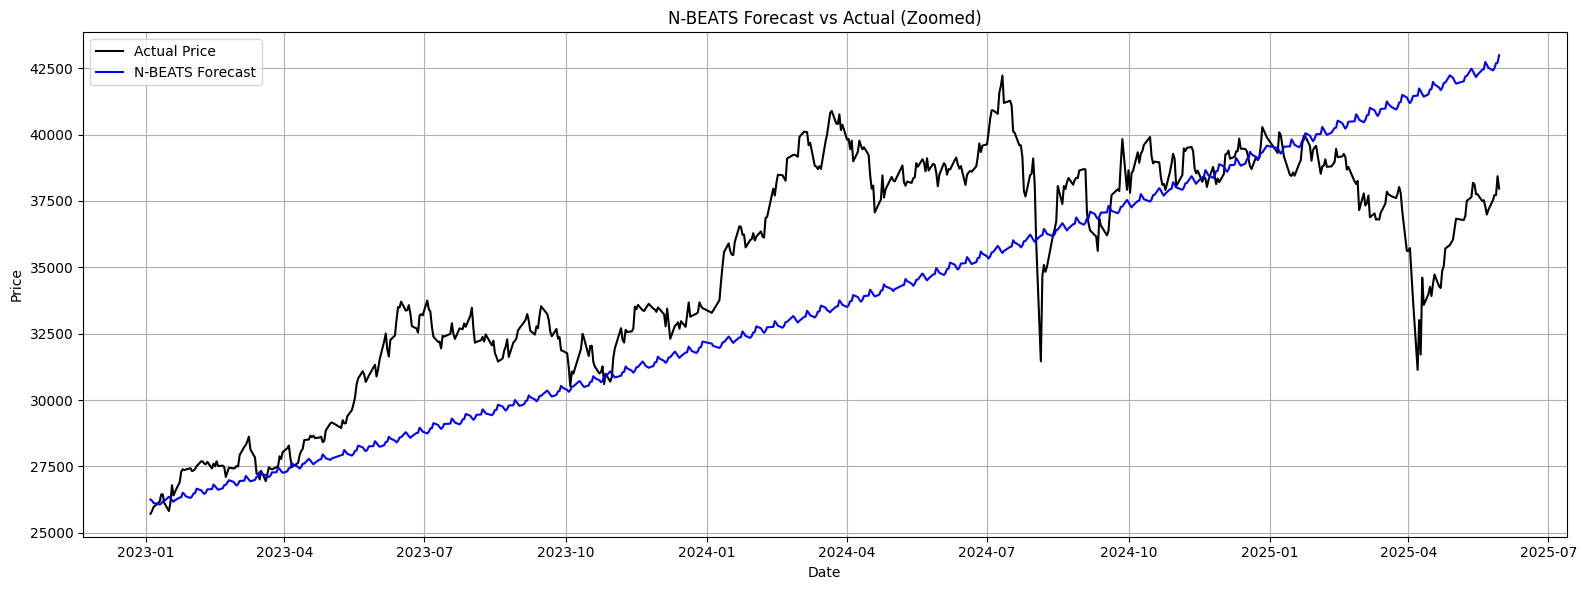

In [ ]:
# Plot Zoomed Forecast (2024–2025)
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"
zoom_idx = (test_dates >= zoom_start) & (test_dates <= zoom_end)

plt.figure(figsize=(16, 6))
plt.plot(test_dates[zoom_idx], actual_prices[zoom_idx], label="Actual Price", color="black")
plt.plot(test_dates[zoom_idx], predicted_prices[zoom_idx], label="N-BEATS Forecast", linestyle='-', color="blue")
plt.title("N-BEATS Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
min_len = min(len(predicted_prices), len(actual_prices))
result = evaluate_forecast(
    y_true=actual_prices[:min_len],
    y_pred=predicted_prices.values[:min_len],
    model_name="N-BEATS"
)

Evaluation for N-BEATS:
MAE:  2617.65
RMSE: 3311.61
MAPE: 15.48%
